# [POC] Foetal Health Classification w Scikit-learn

This dataset contains **2126** records of features extracted from Cardiotocogram exams, which were then classified by three expert obstetritians into 3 classes:

1. Normal
2. Suspect
3. Pathological

The dataset is obtained from [Kaggle.com](https://www.kaggle.com/), an online machine learning community.

Link to the dataset is [Here](https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification?resource=download)

## **1. Importing Packages**

In [1]:
# General Python imports
import os
import gc
import time
import tqdm
import random

os.environ['KERAS_BACKEND'] = 'tensorflow'

import numpy as np
import pandas as pd
from itertools import cycle

# Visualisation imports
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')     

# Machine Learning libraries
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [2]:
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        FILE_PATH = os.path.join(dirname, filename)
        print(FILE_PATH)

input/fetal_health.csv


## **2. Config**

In [3]:
SEED = 123
random.seed(SEED)

TEST_SIZE = 0.20
VAL_SIZE = 0.15

EPOCHS = 100
BATCH_SIZE = 4

## **3. Data**

### 3.1 Loading the Data

In [4]:
data = pd.read_csv(FILE_PATH)
data.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
baseline value,2126.0,133.303857,9.840844,106.0,126.000,133.000,140.000,160.000
accelerations,2126.0,0.003178,0.003866,0.0,0.000,0.002,0.006,0.019
fetal_movement,2126.0,0.009481,0.046666,0.0,0.000,0.000,0.003,0.481
uterine_contractions,2126.0,0.004366,0.002946,0.0,0.002,0.004,0.007,0.015
light_decelerations,2126.0,0.001889,0.002960,0.0,0.000,0.000,0.003,0.015
severe_decelerations,2126.0,0.000003,0.000057,0.0,0.000,0.000,0.000,0.001
prolongued_decelerations,2126.0,0.000159,0.000590,0.0,0.000,0.000,0.000,0.005
abnormal_short_term_variability,2126.0,46.990122,17.192814,12.0,32.000,49.000,61.000,87.000
mean_value_of_short_term_variability,2126.0,1.332785,0.883241,0.2,0.700,1.200,1.700,7.000
percentage_of_time_with_abnormal_long_term_variability,2126.0,9.846660,18.396880,0.0,0.000,0.000,11.000,91.000


### 3.2 Data Analysis

The analysis consist of:

* Count Plot
* Correlation Heat Map
* Implot
* Swarm And Boxen Plot

<Axes: xlabel='fetal_health', ylabel='count'>

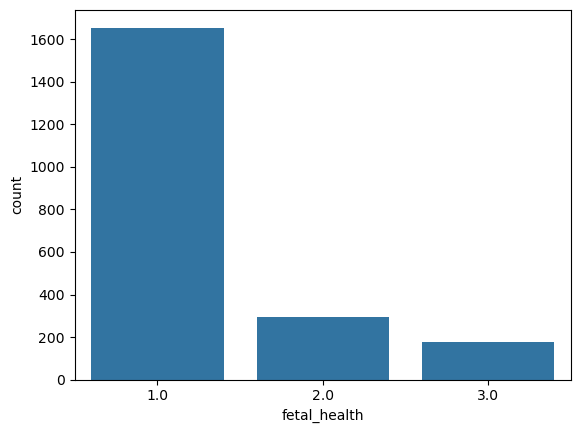

In [7]:
# To check if the data is imbalanced or not
sns.countplot(data=data, x="fetal_health")

The count plot of targets indicates an imbalance in data. This is a case that tends to provide misleading classification accuracy.


<Axes: >

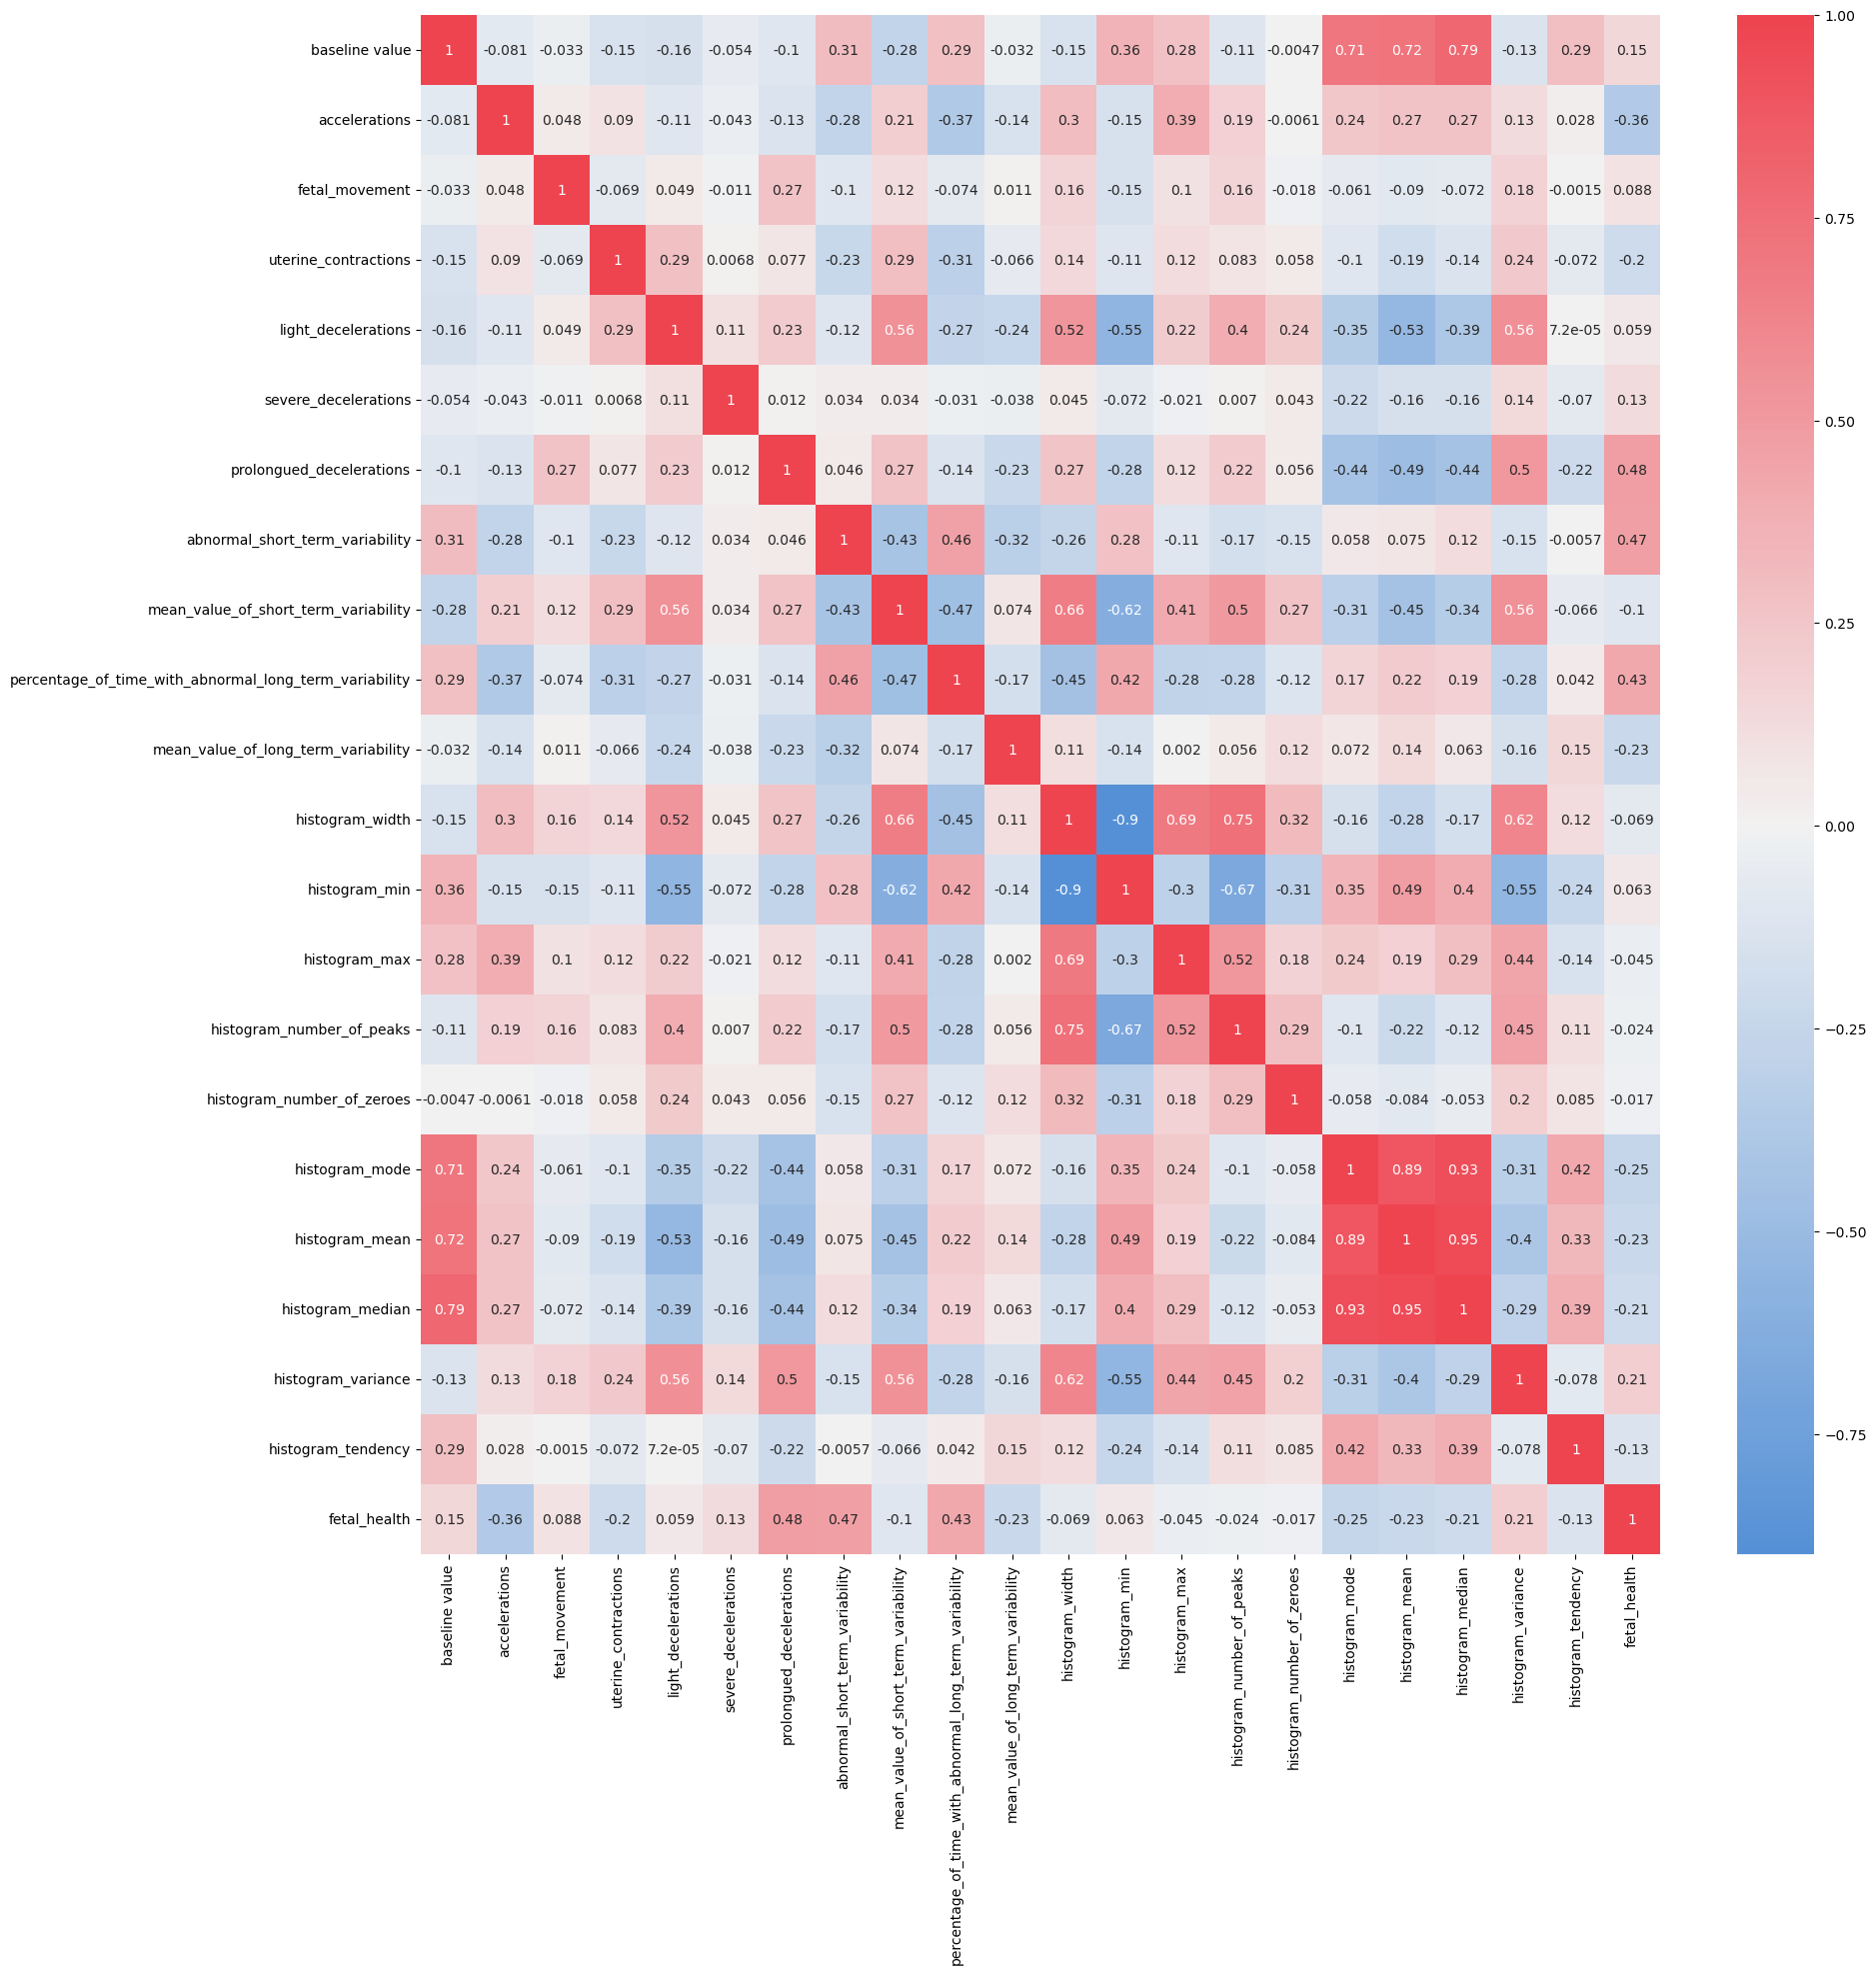

In [30]:
# Correlation matrix
corrmat= data.corr()
plt.figure(figsize=(20,20))  

cmap = sns.diverging_palette(250, 10, s=80, l=55, n=9, as_cmap=True)

sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

Based on the correlation matix, we can infer that
1. "accelerations"
2. "prolongued_decelerations"
3. "abnormal_short_term_variability"
4. "percentage_of_time_with_abnormal_long_term_variability"

are the features with higher correlation with fetal_health.

### 3.3 Correlation with Fetal Movement and Fetal Health

**1. Accelerations**

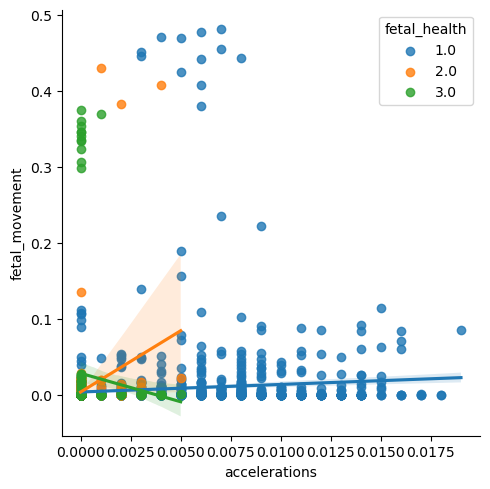

In [9]:
sns.lmplot(data=data,x="accelerations",y="fetal_movement", hue="fetal_health",legend_out=False)
plt.show()

**Insights:**
* There seems to be a positive correlation between accelerations and fetal movement generally.
* But this might not be the case with pathological condition (3.0), which displayed a negative correlation.
* Better normal fetal health (1.0) is associated with higher fetal movement at any given level of accelerations compared to suspected (2.0) or pathological conditions (3.0).

**2. Prolonged Decelerations**

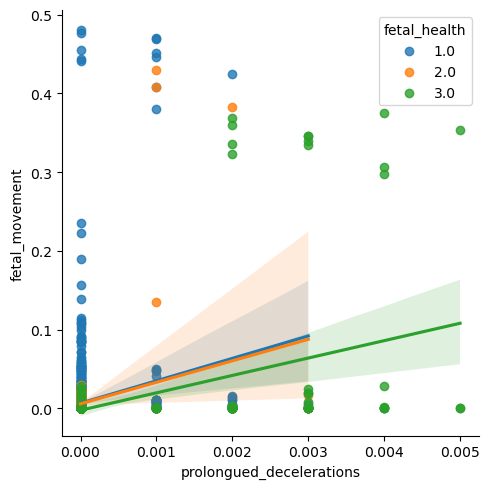

In [10]:
sns.lmplot(data =data,x="prolongued_decelerations",y="fetal_movement", hue="fetal_health",legend_out=False)
plt.show()

**Insights**
* The plot suggests a general increase in fetal movement with increased prolonged decelerations, but the relationship is not as strong as with accelerations. The data dispersion indicates variability in fetal movement at low levels of prolonged decelerations.
* Normal fetal health shows less impact on movement from prolonged decelerations, whereas suspected or pathological conditions show more variability and potentially reduced movement at higher levels of decelerations.

**3. Abnormal Short Term Variability**

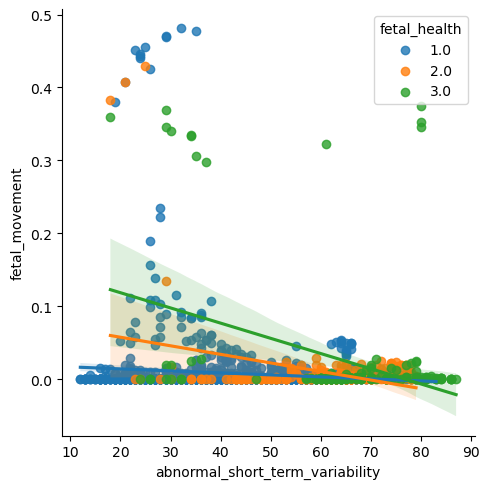

In [11]:
sns.lmplot(data =data,x="abnormal_short_term_variability",y="fetal_movement", hue="fetal_health",legend_out=False)
plt.show()

**Insight**
* Abnormal short-term variability shows a negative correlation with fetal movement. As the abnormal short-term variability increases, fetal movement decreases, which could be indicative of distress or less well-being of the fetus.
* Normal fetal health shows relatively high fetal movement across a range of abnormal short-term variability, whereas suspected or pathological conditions are associated with less movement, especially as variability increases.

### 3.4 Outlier

In [12]:
# columns for detailed visualisation
cols=['baseline value', 'accelerations', 'fetal_movement',
       'uterine_contractions', 'light_decelerations', 'severe_decelerations',
       'prolongued_decelerations', 'abnormal_short_term_variability',
       'mean_value_of_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability',
       'mean_value_of_long_term_variability']

In [13]:
# for i in tqdm.tqdm(cols):
#     sns.swarmplot(x=data["fetal_health"], y=data[i], color="black", alpha=0.5 )
#     sns.boxenplot(x=data["fetal_health"], y=data[i])
#     plt.show()

We can clearly spot some outliers in our dataset. However, it is not quite a good idea to remove them yet as it may lead to overfitting. Though we may end up with better statistics.

A basic rule of thumb for the outliers in question is:
* It is a measurement error or data entry error, correct the error if possible. If you can’t fix it, remove that observation. In our case, this is the outcome of a CTG report so it is unlikely that this was a data entry error.
* If it is not a part of the population you are studying, you can legitimately remove the outlier. In this case, this all is about the fetus, and experts tag the classification. Let's stick with the expert opinion.

Thus assuming that these are the natural part of the population we are studying, we should not remove it.

### 3.5 Feature Scaling

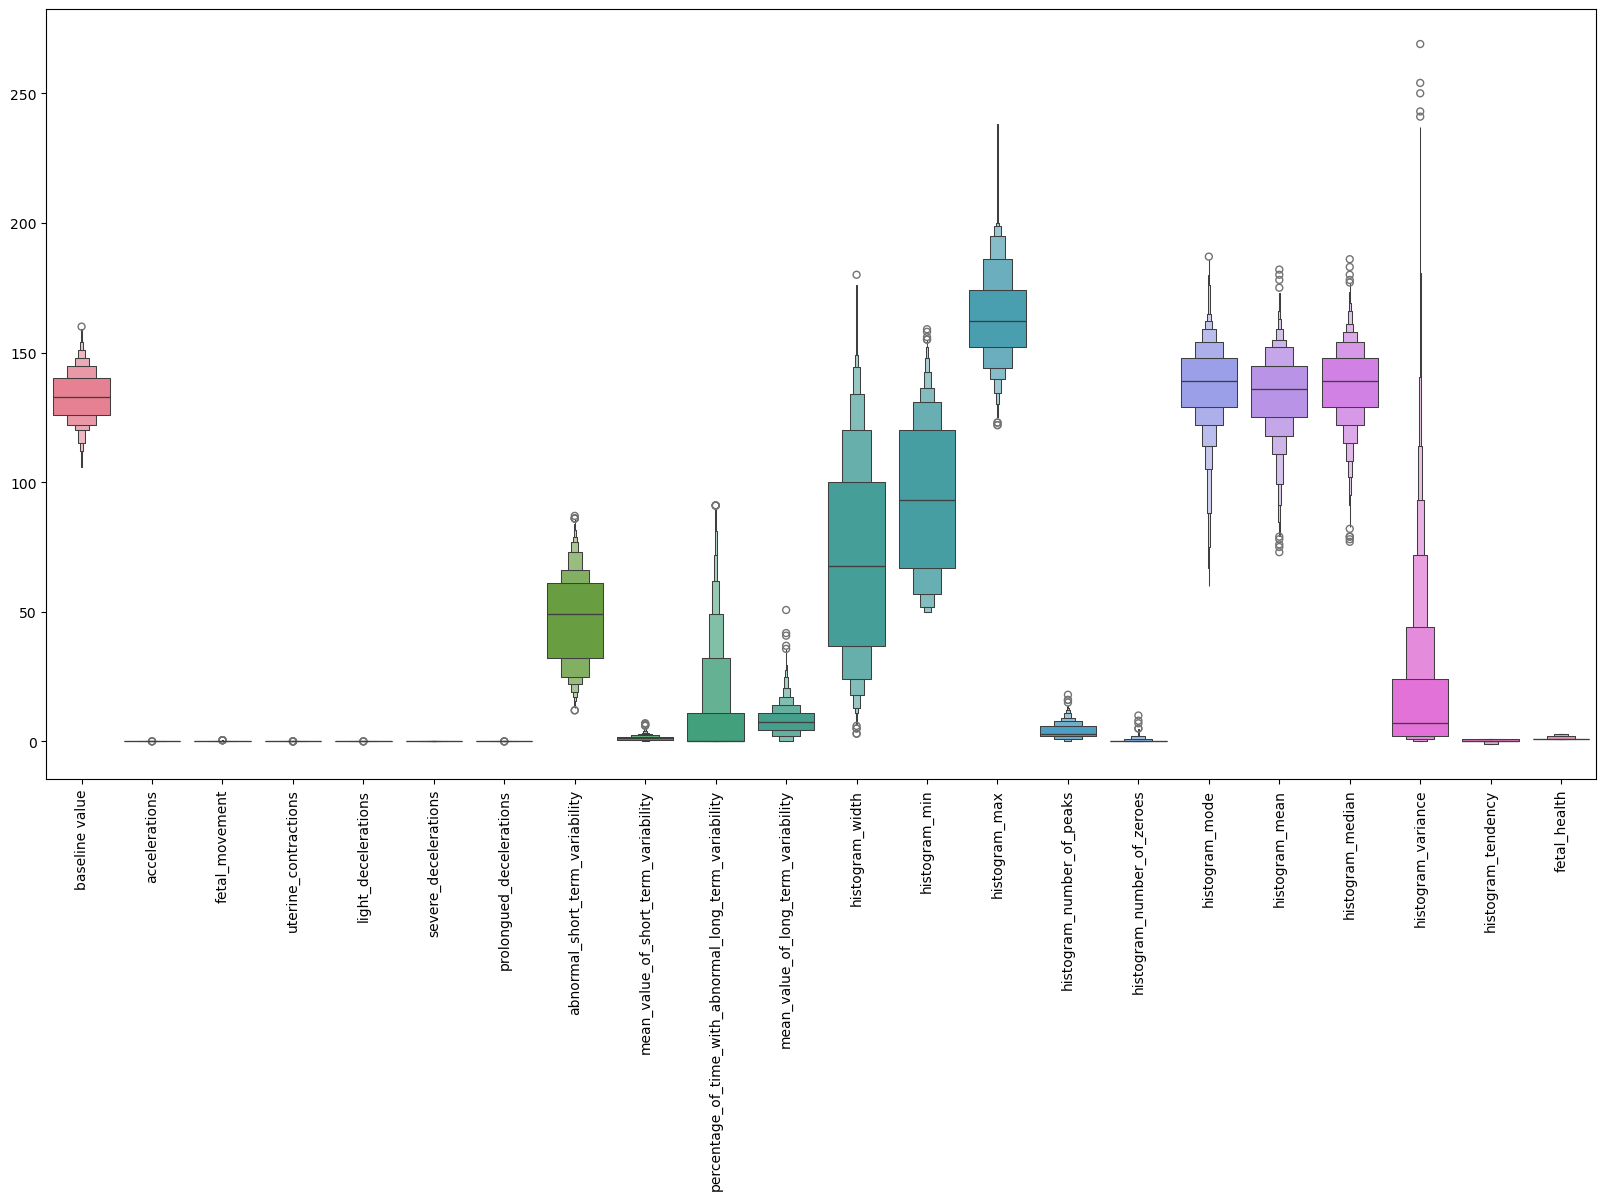

In [14]:
plt.figure(figsize=(20,10))
sns.boxenplot(data = data)
plt.xticks(rotation=90)
plt.show()

The above plot shows the range of our feature attributes.

All the features are in different ranges. To fit this in a model we must scale it to the same range. -> StandardScaler

In [15]:
X = data.drop(["fetal_health"],axis=1)
y = data["fetal_health"]

#Set up a standard scaler for the features
col_names = list(X.columns)
s_scaler = preprocessing.StandardScaler()
X_df= s_scaler.fit_transform(X)
X_df = pd.DataFrame(X_df, columns=col_names)   
X_df.describe().T

,count,mean,std,min,25%,50%,75%,max
baseline value,2126.0,1.069490e-15,1.000235,-2.775197,-0.742373,-0.030884,0.680604,2.713428
accelerations,2126.0,-4.010589e-17,1.000235,-0.822388,-0.822388,-0.304881,0.730133,4.093929
fetal_movement,2126.0,-1.336863e-17,1.000235,-0.203210,-0.203210,-0.203210,-0.138908,10.106540
uterine_contractions,2126.0,-1.336863e-16,1.000235,-1.482465,-0.803434,-0.124404,0.894142,3.610264
light_decelerations,2126.0,-5.347452e-17,1.000235,-0.638438,-0.638438,-0.638438,0.375243,4.429965
severe_decelerations,2126.0,6.684315e-18,1.000235,-0.057476,-0.057476,-0.057476,-0.057476,17.398686
prolongued_decelerations,2126.0,1.336863e-17,1.000235,-0.268754,-0.268754,-0.268754,-0.268754,8.208570
abnormal_short_term_variability,2126.0,-7.352747e-17,1.000235,-2.035639,-0.872088,0.116930,0.815060,2.327675
mean_value_of_short_term_variability,2126.0,6.684315e-17,1.000235,-1.282833,-0.716603,-0.150373,0.415857,6.417893
percentage_of_time_with_abnormal_long_term_variability,2126.0,-5.347452e-17,1.000235,-0.535361,-0.535361,-0.535361,0.062707,4.412293


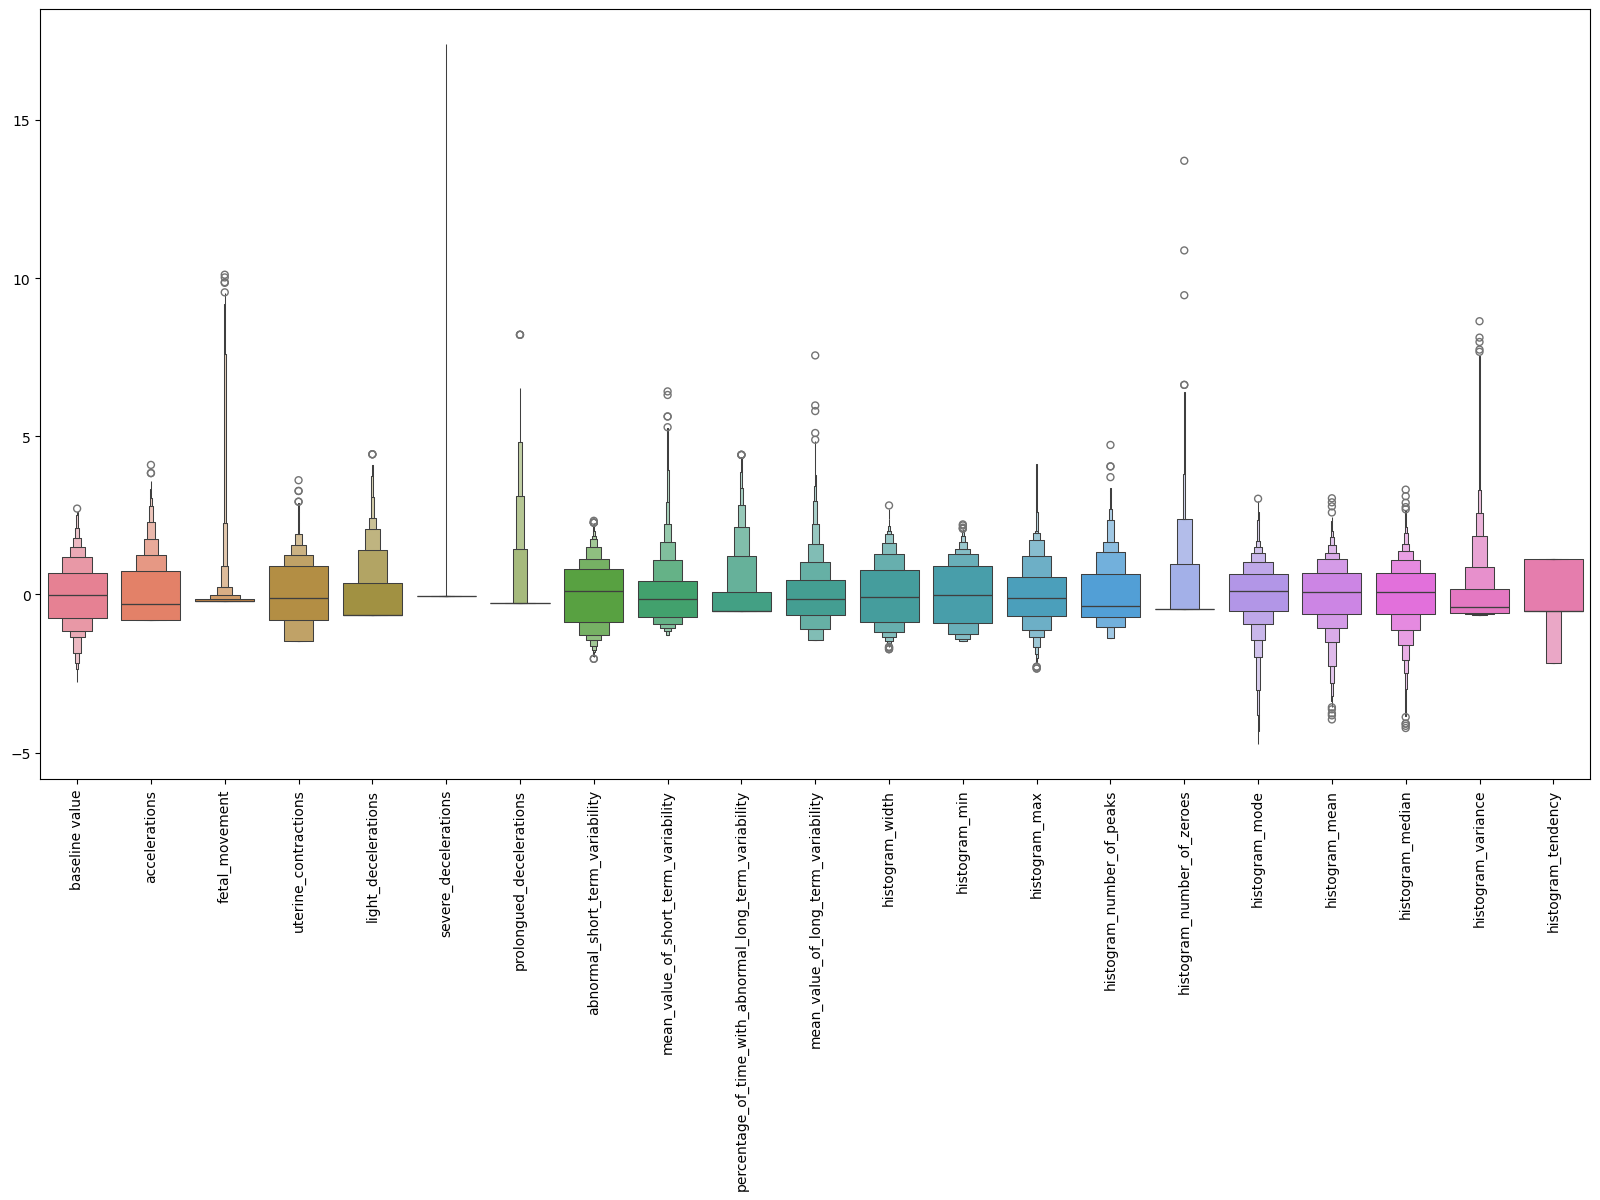

In [16]:
# Display scaled features
plt.figure(figsize=(20,10))
sns.boxenplot(data = X_df)
plt.xticks(rotation=90)
plt.show()

## **4. Model**

### 4.1 Model Selection & Building

In [17]:
# Spliting training and test sets
X_train, X_test, y_train,y_test = train_test_split(X_df,y,test_size=0.3,random_state=42)

In [18]:
# A quick model selection process
pipeline_lr=Pipeline([('lr_classifier',LogisticRegression(random_state=42))])

pipeline_dt=Pipeline([ ('dt_classifier',DecisionTreeClassifier(random_state=42))])

pipeline_rf=Pipeline([('rf_classifier',RandomForestClassifier())])

pipeline_svc=Pipeline([('sv_classifier',SVC())])

pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_svc]

pipe_dict = {0: 'Logistic Regression', 1: 'Decision Tree', 2: 'RandomForest', 3: "SVC"}

In [19]:
# Fit the pipelines
for pipe in tqdm.tqdm(pipelines):
    pipe.fit(X_train, y_train)

# Cross validation on accuracy 
cv_results_accuracy = []
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, X_train,y_train, cv=10 )
    cv_results_accuracy.append(cv_score)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

print("\n")

for i, model in enumerate(pipelines):
    y_pred = cross_val_predict(model, X_train, y_train, cv=10)
    print(f"{pipe_dict[i]}:\n{classification_report(y_train, y_pred)}")

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 22.86it/s]


Logistic Regression: 0.897170 
Decision Tree: 0.916683 
RandomForest: 0.937511 
SVC: 0.906594 


Logistic Regression:
              precision    recall  f1-score   support

         1.0       0.94      0.96      0.95      1159
         2.0       0.66      0.64      0.65       194
         3.0       0.82      0.76      0.79       135

    accuracy                           0.90      1488
   macro avg       0.81      0.79      0.80      1488
weighted avg       0.90      0.90      0.90      1488

Decision Tree:
              precision    recall  f1-score   support

         1.0       0.95      0.96      0.95      1159
         2.0       0.73      0.70      0.71       194
         3.0       0.88      0.88      0.88       135

    accuracy                           0.92      1488
   macro avg       0.85      0.85      0.85      1488
weighted avg       0.92      0.92      0.92      1488

RandomForest:
              precision    recall  f1-score   support

         1.0       0.95      0.98   

So Random Forest does best amongst the models to be the most accurate.

We will now build a better random forest with grid search cv and see how performs on testset

In [20]:
pred_rfc = pipeline_rf.predict(X_test)
accuracy = accuracy_score(y_test, pred_rfc)
print(f"Accuracy of RF on test set: {accuracy}")

Accuracy of RF on test set: 0.9373040752351097


In [22]:
# Build a dictionary with list of parameter values that can be analysed by GridSearch CV
parameters = { 
    'n_estimators': [100, 150, 200, 500, 700, 900],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4, 6, 8, 12, 14, 16],
    'criterion' :['gini', 'entropy'],
    'n_jobs':[-1, 1, None]
}

#Fitting the training set to find parameters with best accuracy
CV_rfc = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parameters, cv=5, verbose=3)
CV_rfc.fit(X_train, y_train)

# Getting the best parameters from the gridsearch
CV_rfc.best_params_


Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[CV 1/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=100, n_jobs=-1;, score=0.906 total time=   0.9s
[CV 2/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=100, n_jobs=-1;, score=0.899 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=100, n_jobs=-1;, score=0.886 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=100, n_jobs=-1;, score=0.889 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=100, n_jobs=-1;, score=0.919 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=100, n_jobs=1;, score=0.906 total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=100, n_jobs=1;, score=0.893 total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=100, n_jobs=1;, score=0.889 total time=   0.1s
[CV 4/5] END criterion=gini

{'criterion': 'entropy',
 'max_depth': 14,
 'max_features': 'log2',
 'n_estimators': 200,
 'n_jobs': -1}

In [23]:
# Train the model using the best parameters found
RF_model = RandomForestClassifier(**CV_rfc.best_params_)
RF_model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=14, max_features='log2',
                       n_estimators=200, n_jobs=-1)

In [24]:
# Testing the model on test set
y_pred = RF_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average="weighted")
precision = precision_score(y_test, y_pred, average="weighted")
f1_score = f1_score(y_test, y_pred, average="micro")

print("********* Random Forest Results *********")
print("Accuracy    : ", accuracy)
print("Recall      : ", recall)
print("Precision   : ", precision)
print("F1 Score    : ", f1_score)

********* Random Forest Results *********
Accuracy    :  0.9482758620689655
Recall      :  0.9482758620689655
Precision   :  0.9475673568699188
F1 Score    :  0.9482758620689655


In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.96      0.98      0.97       496
         2.0       0.92      0.78      0.84       101
         3.0       0.88      0.93      0.90        41

    accuracy                           0.95       638
   macro avg       0.92      0.90      0.91       638
weighted avg       0.95      0.95      0.95       638



<Axes: >

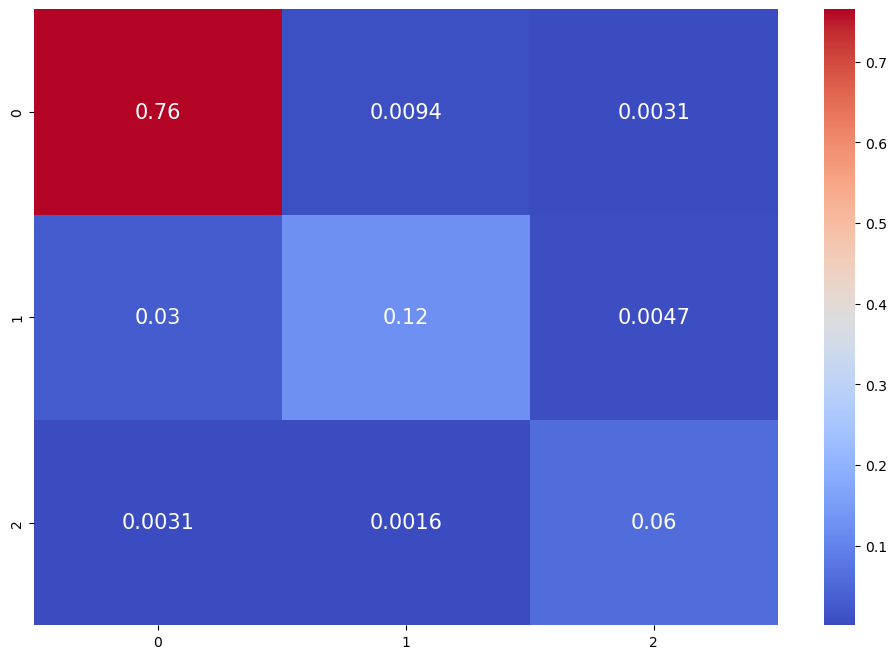

In [26]:
# Confusion matrix
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix),cmap="coolwarm" ,annot = True, annot_kws = {'size':15})
